In [1]:
!pip install -r requirements.txt

  Using cached numpy-1.26.4-cp39-cp39-macosx_11_0_arm64.whl (14.0 MB)
  Using cached pandas-1.5.3-cp39-cp39-macosx_11_0_arm64.whl (11.0 MB)
     |████████████████████████████████| 252.5 MB 163 kB/s eta 0:00:013     |████████████████████            | 157.0 MB 2.8 MB/s eta 0:00:35
     |████████████████████████████████| 1.3 MB 8.8 MB/s eta 0:00:01
  Using cached matplotlib-3.9.2-cp39-cp39-macosx_11_0_arm64.whl (7.8 MB)
     |████████████████████████████████| 9.5 MB 10.5 MB/s eta 0:00:01
     |████████████████████████████████| 275 kB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 509 kB 9.5 MB/s eta 0:00:01
     |████████████████████████████████| 71 kB 1.5 MB/s  eta 0:00:01
     |████████████████████████████████| 135 kB 7.8 MB/s eta 0:00:01
     |████████████████████████████████| 667 kB 7.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 8.7 MB/s eta 0:00:01
     |████████████████████████████████| 5.5 MB 6.6 MB/s eta 0:00:01
     |███████████████████████████

In [2]:
"""Load libraries"""

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Reshape, AdditiveAttention
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import lime
import lime.lime_tabular

import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

/Users/deniszahariev/Desktop/Uni/Explainable AI/final project stocks/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
%matplotlib inline

In [3]:
def set_global_determinism(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(42)
tf.config.experimental.enable_op_determinism()

# 1. EDA

In [4]:
df=pd.read_csv("data/TSLA.csv")
#df = pd.read_csv("NFLX.csv")
df["Date"]=pd.to_datetime(df["Date"])
df.index=df["Date"]
df.drop("Date",axis=1,inplace=True)
print("Number of records: ",df.shape[0])
df.head()

Number of records:  2416


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [5]:
df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [6]:
print("Start date", df.index.min())
print("End date", df.index.max())

Start date 2010-06-29 00:00:00
End date 2020-02-03 00:00:00


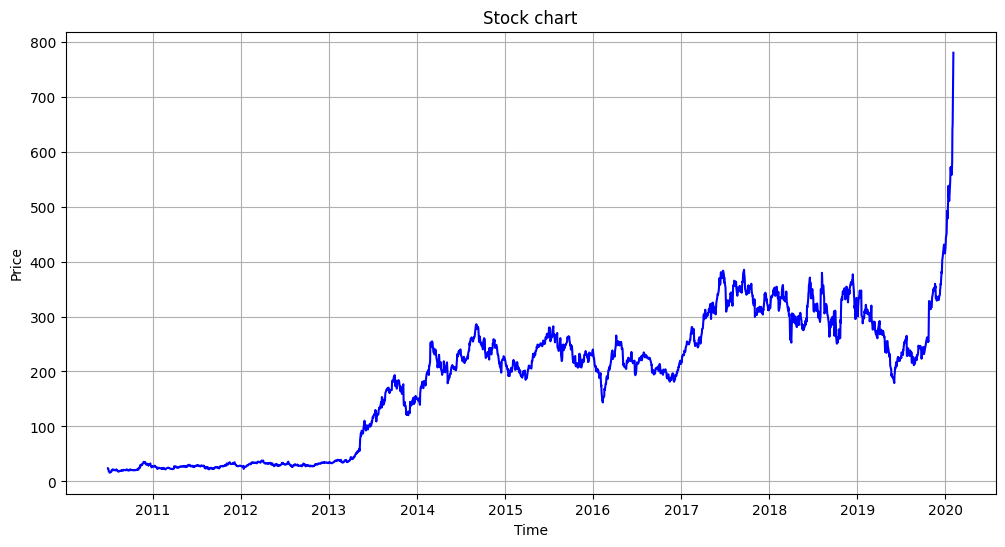

In [7]:
plt.figure(figsize=(12,6))
plt.plot(df["Close"],color="blue")
plt.ylabel("Price")
plt.title("Stock chart")
plt.xlabel("Time")
plt.grid()
plt.show()

# 2. Preparing data for modeling

In [8]:
N_STEPS = 20

In [9]:
training_data = df['Close'].values.reshape(-1,1)

In [10]:
# Split the data into training and testing sets with 80% for training and 20% for testing, don't shuffle
# as we want to keep the time series order
train_data, test_data = train_test_split(training_data, test_size=0.2, shuffle=False)
print(train_data.shape,test_data.shape)

(1932, 1) (484, 1)


In [11]:
scaler = MinMaxScaler(feature_range=(0,1))

scaler.fit(train_data)

train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [12]:
def create_features(data):
    X,Y=[],[]
    for i in range(N_STEPS,len(data)):
        X.append(data[i-N_STEPS:i,0])
        Y.append(data[i,0])
    return np.array(X),np.array(Y)

In [13]:
X_train, y_train=create_features(train_data)
X_test, y_test=create_features(test_data)

# Transform the data into 3D shape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1912, 20), (1912, 1), (464, 20), (464, 1))

# 3. Modeling

In [14]:
#clear backend
tf.keras.backend.clear_session()

In [15]:
# Model with LSTM and Additive Attention

def get_lstm_attention_model():
    inputs = Input(shape=(X_train.shape[1], 1))
    x = LSTM(50, return_sequences=True, activation="relu",)(inputs)
    x = Dropout(0.2)(x)
    attention_output = AdditiveAttention()([x, x])
    x = LSTM(50, return_sequences=False)(attention_output)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

def get_lstm_model():
    model=Sequential()
    model.add(Reshape((N_STEPS,1)))
    model.add(LSTM(units=50,
                activation="relu",
                input_shape=(N_STEPS, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

In [16]:
model = get_lstm_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
callbacks=[EarlyStopping(monitor="val_loss",patience=3,verbose=1,mode="min"),
          ModelCheckpoint(filepath="models/lstm_model_new.keras",monitor="val_loss",mode="min",
                         save_best_only=True,save_weights_only=False,verbose=1)]

In [18]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=100,
                    batch_size=20,
                    validation_data=(X_test,y_test),
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/100
84/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0554 
Epoch 1: val_loss improved from inf to 0.55062, saving model to models/lstm_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0746 - val_loss: 0.5506
Epoch 2/100
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0484 
Epoch 2: val_loss improved from 0.55062 to 0.45945, saving model to models/lstm_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0585 - val_loss: 0.4595
Epoch 3/100
85/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0357 
Epoch 3: val_loss improved from 0.45945 to 0.37983, saving model to models/lstm_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0477 - val_loss: 0.3798
Epoch 4/100
87/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0303 
Epoch 4: val_loss improved from 0.37983 to 0.30627, saving model to models/lstm_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0385 - val_loss: 0.3063
Epoch 5/100
87/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0237
Epoch 5: v

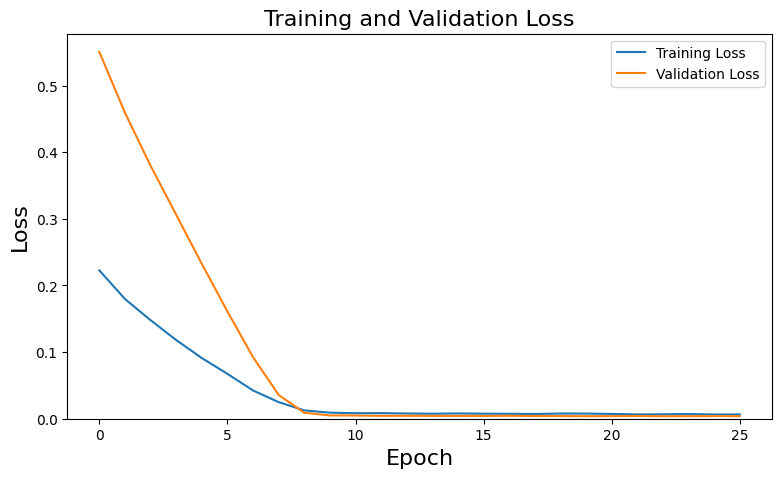

In [19]:
def plot_loss_curve(history):
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,2)
    plt.plot(history.history["loss"],label="Training Loss")
    plt.plot(history.history["val_loss"],label="Validation Loss")
    plt.legend(loc="upper right")
    plt.xlabel("Epoch",fontsize=16)
    plt.ylabel("Loss",fontsize=16)
    plt.ylim([0,max(plt.ylim())])

    if len(history.history["loss"])>20:
        plt.xticks(list(range(0,len(history.history["loss"]),5)))
    else:
        plt.xticks(list(range(0,len(history.history["loss"]))))
    plt.title("Training and Validation Loss",fontsize=16)
    plt.show()

plot_loss_curve(history)

# 4. Evaluation

In [20]:
model = tf.keras.models.load_model("models/lstm_model.keras")

In [21]:
loss=model.evaluate(X_test,y_test,batch_size=20)

print("\nTest loss: ",loss)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034  

Test loss:  0.0038028003182262182


In [22]:
train_predictions=model.predict(X_train)
test_predictions=model.predict(X_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


RMSE:  22.77


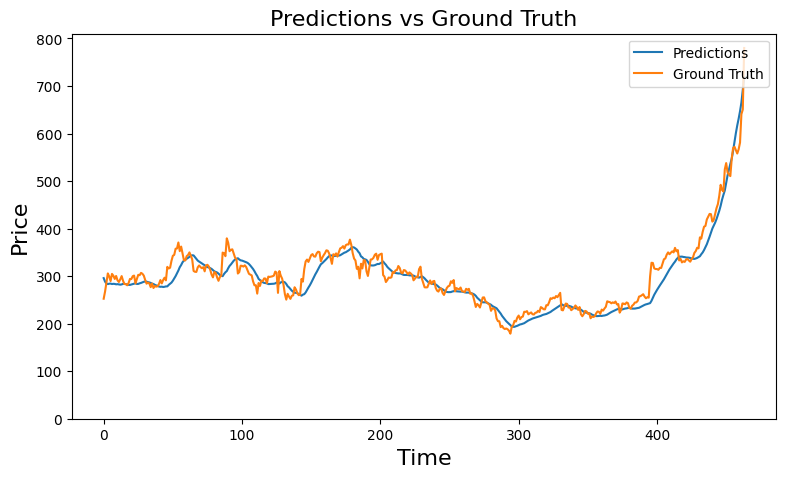

RMSE:  11.38


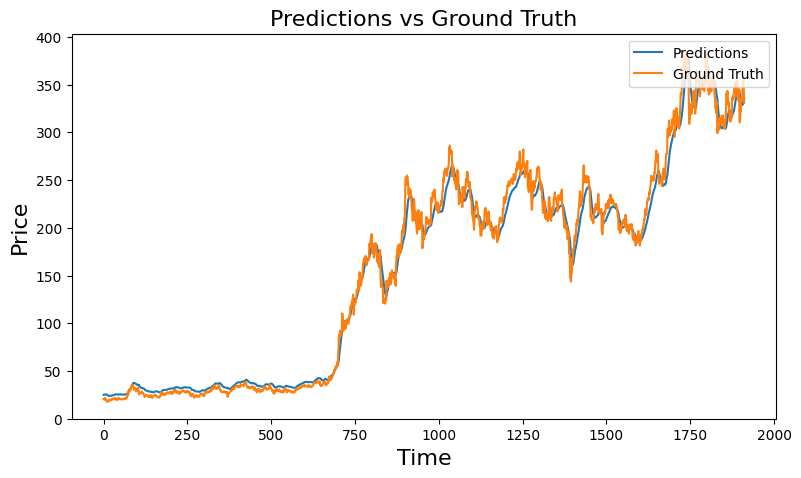

In [23]:
def plot_preds_gt(preds, gt):

    if preds.max() <=10:
        preds = scaler.inverse_transform(preds)

    if gt.max() <=10:
        gt = scaler.inverse_transform(gt)

    rmse = np.sqrt(mean_squared_error(preds, gt))
    print("RMSE: ", np.round(rmse,2))
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,2)
    plt.plot(preds, label="Predictions")
    plt.plot(gt, label="Ground Truth")
    plt.legend(loc="upper right")
    plt.xlabel("Time",fontsize=16)
    plt.ylabel("Price",fontsize=16)
    plt.ylim([0,max(plt.ylim())])
    plt.title("Predictions vs Ground Truth",fontsize=16)
    plt.show()
plot_preds_gt(test_predictions, y_test)
plot_preds_gt(train_predictions, y_train)

In [24]:
results=df.copy()
pos = int(df.shape[0]*0.8)
pos

1932

In [25]:

if train_predictions.max() <=10:
    train_predictions = scaler.inverse_transform(train_predictions)
if test_predictions.max() <=10:
    test_predictions = scaler.inverse_transform(test_predictions)


train_prediction_data=df.copy()[N_STEPS:pos]
train_prediction_data["Predicted"]=train_predictions

test_prediction_data=df.copy()[pos+N_STEPS:]
test_prediction_data["Predicted"]=test_predictions

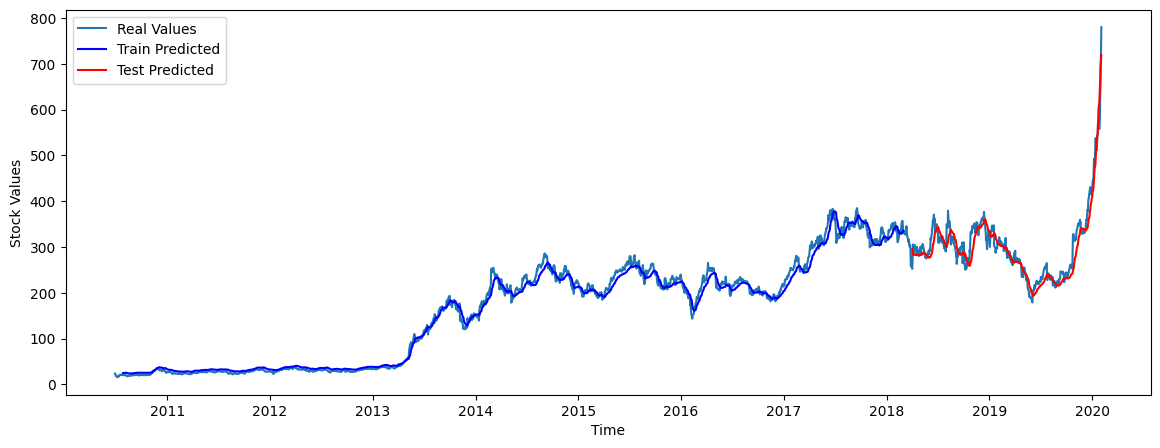

In [26]:
plt.figure(figsize=(14,5))
plt.plot(df['Close'],label="Real Values")
plt.plot(train_prediction_data["Predicted"],color="blue",label="Train Predicted")
plt.plot(test_prediction_data["Predicted"],color="red",label="Test Predicted")
plt.xlabel("Time")
plt.ylabel("Stock Values")
plt.legend()
plt.show()

In [27]:
df['Predicted'] = np.nan
df.iloc[N_STEPS:pos, df.columns.get_loc('Predicted')] = train_predictions
df.iloc[pos+N_STEPS:, df.columns.get_loc('Predicted')] = test_predictions

# Integrated Gradients

In [28]:
def get_timesteps(idx: int, N=20) -> tf.Tensor:
    """Load the last 20 days of data for prediction.

    Args:
        idx (int): The index of the data to be predicted.
        N (int): The number of timesteps to use for prediction.

    Returns:
        tf.Tensor: The input data for prediction with shape (20, 1).
    """

    assert idx > N, "Index must be greater than the number of timesteps ({}).".format(N)
    assert idx < df.shape[0], "Index must be less than the number of records ({}).".format(df.shape[0])
    # get the last N days of data
    input_data = df['Close'].values[idx-N:idx].reshape(1,N,1)
    # scale the data
    # input_data = scaler.transform(input_data)
    # convert to tensor
    input_data = tf.convert_to_tensor(input_data, dtype=tf.float32)
    return input_data

sample_input = get_timesteps(30)
sample_input.shape

TensorShape([1, 20, 1])

In [29]:
def interpolate_input(input: tf.Tensor, steps: int = 20, baseline_type="zeros") -> tf.Tensor:
    """ Create scaled inputs for Integrated Gradients.
    Args:
        input (tf.Tensor): Input tensor to be scaled.
        steps (int, optional): Number of steps for scaling. Defaults to 20.

    Returns:
        tf.Tensor: Scaled inputs tensor with shape (steps, 20, 1).
    """

    if input.shape[0] == 1:
        input = tf.squeeze(input, axis=0)

    if baseline_type == "mean":
        baseline = tf.ones_like(input, dtype=tf.float32) * 0.5
    elif baseline_type == "zeros":
        baseline = tf.zeros_like(input, dtype=tf.float32)
    elif baseline_type == "random":
        baseline = tf.random.uniform(shape=input.shape, minval=0, maxval=1, dtype=tf.float32)

    alphas = tf.linspace(0.0, 1.0, steps)
    scaled_inputs = []
    for alpha in alphas:
        scaled_inputs.append(baseline + alpha * (input - baseline))
    scaled_inputs = tf.stack(scaled_inputs)
    scaled_inputs = tf.transpose(scaled_inputs, perm=[0, 1, 2])
    return scaled_inputs

interpolated_input = interpolate_input(sample_input, steps=40, baseline_type="random")
interpolated_input.shape

TensorShape([40, 20, 1])

In [30]:
def compute_gradients(inputs: tf.Tensor) -> tf.Tensor:
    """ Compute gradients of the model output with respect to the input.
    Args:
        inputs (tf.Tensor): Input tensor.
    Returns:
        tf.Tensor: Gradients of the model output with respect to the input.
    """

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = model(inputs)
        loss = tf.reduce_mean(predictions)
    grads = tape.gradient(loss, inputs)
    return grads

grads = compute_gradients(interpolated_input)
grads.shape

TensorShape([40, 20, 1])

In [31]:
def integral_approximation(gradients: tf.Tensor) -> tf.Tensor:
    """ Approximate the integral of gradients using the trapezoidal rule.
    Args:
        gradients (tf.Tensor): Gradients tensor with shape (steps, N, 1).
    Returns:
        tf.Tensor: Integrated gradients tensor with shape (N, 1).
    """
    # Use the trapezoidal rule to approximate the integral
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

integrated_grads = integral_approximation(grads)
integrated_grads.shape

TensorShape([20, 1])

In [32]:
def plot_integrated_gradients(vals, idx=-1) -> None:
    """ Plot the integrated gradients.
    Args:
        vals (tf.Tensor): Integrated gradients tensor.
        idx (int, optional): Index of the data from the original dataset. Defaults to -1 (last index). This is used to plot the original data with a vertical line at the index.
    """
    import matplotlib.colors as mcolors

    if isinstance(vals, tf.Tensor):
        vals = vals.numpy()
    vals = vals.squeeze()

    x = np.arange(len(vals)) - 20

    vmin, vmax = vals.min(), vals.max()
    max_abs = max(abs(vmin), abs(vmax)) if max(abs(vmin), abs(vmax)) != 0 else 1.0

    bar_colors = []
    for v in vals:
        alpha = 0.9 * (abs(v) / max_abs)
        color = 'red' if v < 0 else 'green'
        bar_colors.append(mcolors.to_rgba(color, alpha=alpha))


    if idx == -1:
        fig, ax = plt.subplots(figsize=(10,4))
        ax.bar(x, vals, edgecolor="black", linewidth=0.5, color=bar_colors)
        ax.set_xlabel("Feature Index (in the past 20 days)")
        ax.set_ylabel("Integrated Gradients")
        ax.set_title("Integrated Gradients for Sample Input")
        ax.set_xticks(x)
        plt.show()
    else:
        fig, axs = plt.subplots(2,1,figsize=(13,6))
        axs[0].bar(x, vals, edgecolor="black", linewidth=0.5, color=bar_colors)
        axs[0].set_xlabel("Feature Index (in the past 20 days)")
        axs[0].set_ylabel("Integrated Gradients")
        axs[0].set_title("Integrated Gradients for Sample Input")
        axs[0].set_xticks(x)

        # add space between the two plots
        plt.subplots_adjust(hspace=0.5)

        axs[1].plot(df['Close'], color="blue")
        axs[1].axvline(x=df.index[idx], color='r', linestyle='--')
        axs[1].axvline(x=df.index[idx-20], color='g', linestyle='--')
        axs[1].set_ylabel("Price")
        axs[1].set_title("Stock chart")
        axs[1].set_xlabel("Time")
        plt.show()

def plot_timeseries_importance(gt, preds, importance_scores):
    fig, ax = plt.subplots()

    if isinstance(importance_scores, tf.Tensor):
        importance_scores = importance_scores.numpy()
    importance_scores = importance_scores.squeeze()


    vmin, vmax = importance_scores.min(), importance_scores.max()
    max_abs = max(abs(vmin), abs(vmax)) if max(abs(vmin), abs(vmax)) != 0 else 1.0

    bar_colors = []
    for v in importance_scores:
        alpha = 0.9 * (abs(v) / max_abs)
        color = 'red' if v < 0 else 'green'
        bar_colors.append(mcolors.to_rgba(color, alpha=alpha))

    lowest_value = np.min(np.concatenate((gt, preds), axis=1))
    highest_value = np.max(np.concatenate((gt, preds), axis=1))

    extent = [-N_STEPS, 0, lowest_value*0.95, highest_value*1.05]
    plt.imshow(np.array([importance_scores]), aspect='auto', cmap='RdYlGn', vmin=min(importance_scores), vmax=max(importance_scores), extent=extent)

    ax.plot(range(-len(gt), 0), gt, color='black',  label='Original Values')
    ax.plot(range(-len(gt), 0), preds, color='blue', label='Predicted Values')

    plt.xticks(range(-len(gt), 0), rotation=45)
    plt.xlabel("Feature Index (in the past 20 days)")
    plt.ylabel("Predicted Values")
    plt.title("Integrated Gradients Importance Scores")
    plt.colorbar(label="Importance Score")
    plt.legend()
    plt.show()

def plot_ig_explanation_for_sample(idx):
    sample_input = get_timesteps(idx)
    preds = df['Predicted'].values[idx-20:idx].reshape(-1, 1)

    interpolated_input = interpolate_input(sample_input, steps=40, baseline_type="random")
    grads = compute_gradients(interpolated_input)
    integrated_grads = integral_approximation(grads)
    plot_integrated_gradients(integrated_grads, idx=idx)
    plot_timeseries_importance(sample_input[0], preds, integrated_grads)



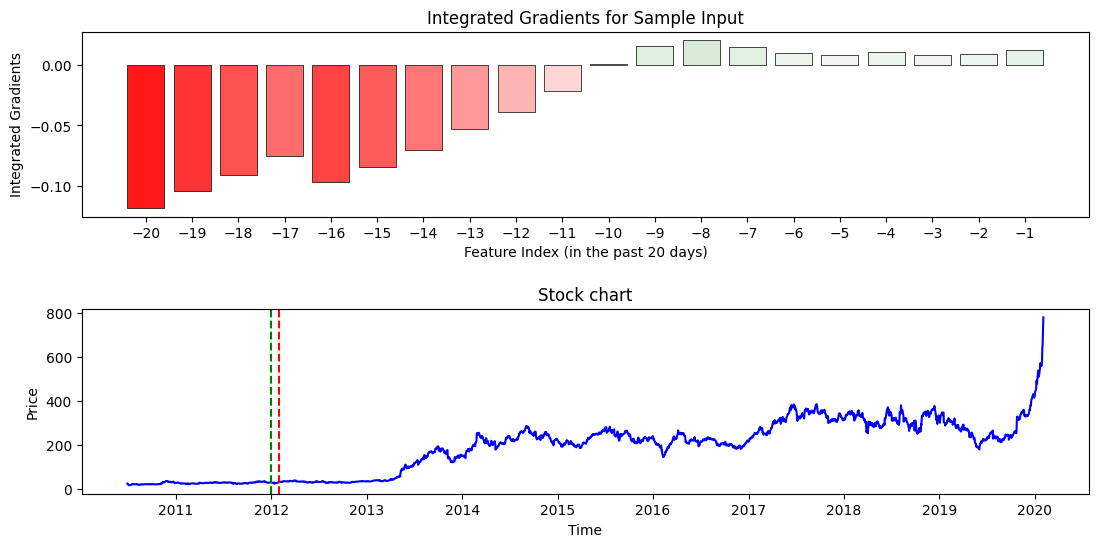

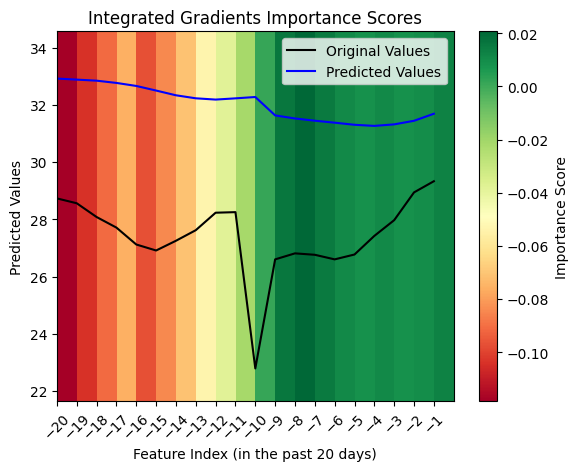

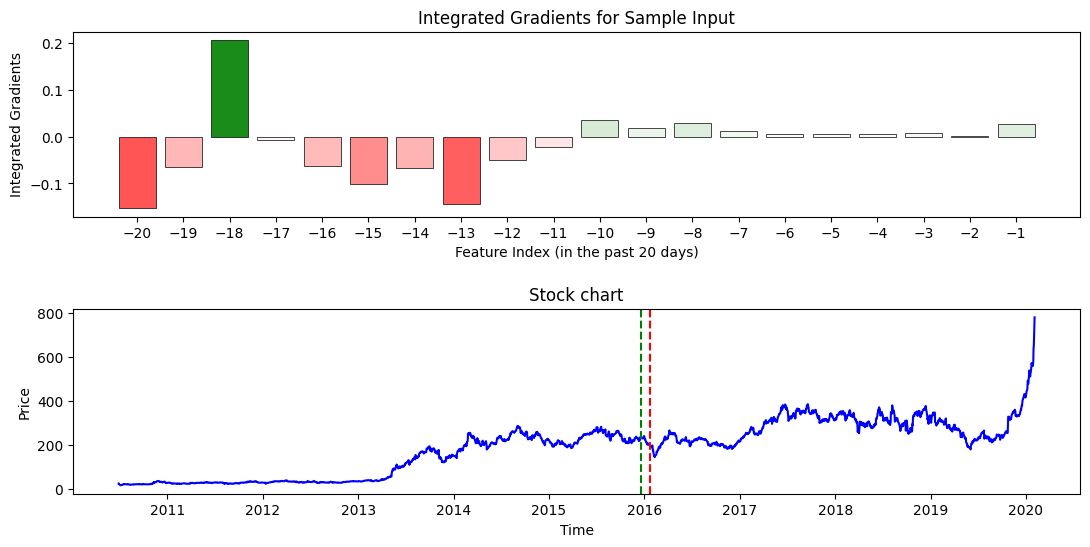

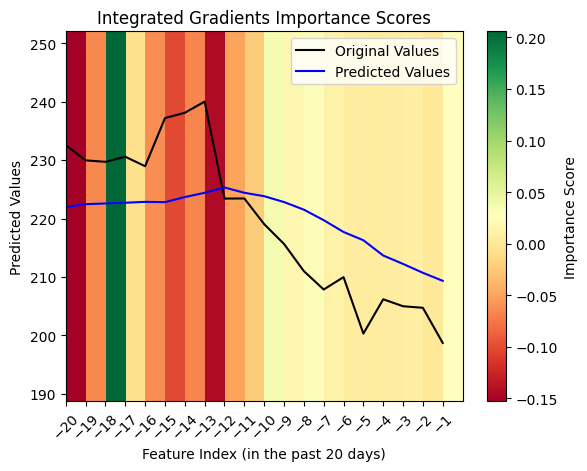

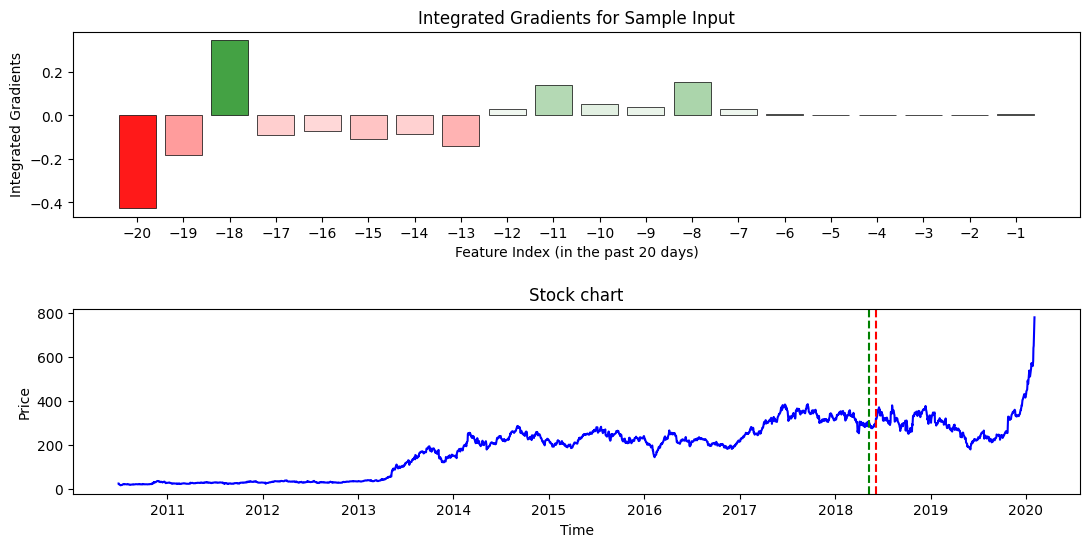

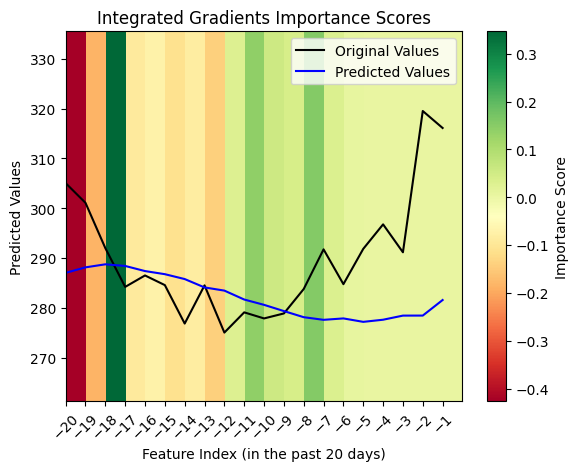

In [33]:
plot_ig_explanation_for_sample(400)
plot_ig_explanation_for_sample(1400)
plot_ig_explanation_for_sample(2000)

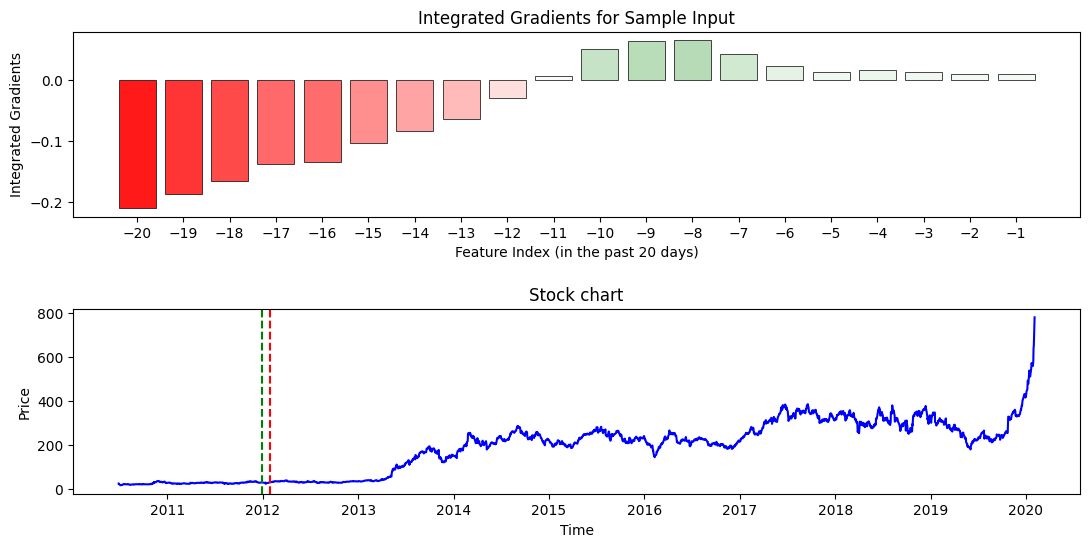

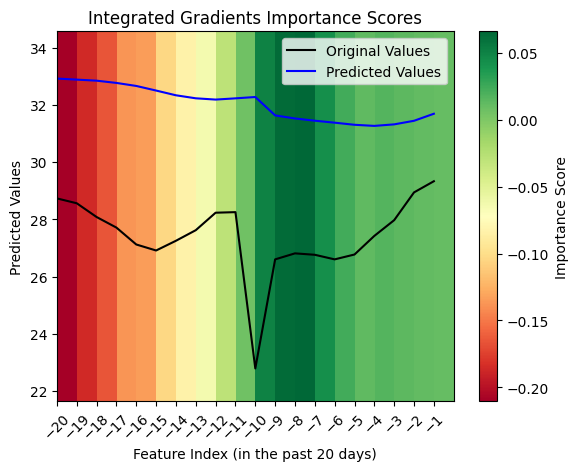

In [42]:
plot_ig_explanation_for_sample(400)

# LIME

In [34]:
class ModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict(self, x):
        # Ensure proper reshaping for time series data
        if len(x.shape) == 2:
            x = x.reshape(x.shape[0], x.shape[1], 1)
        return self.model(x).numpy()


wrapped = ModelWrapper(model)

In [35]:
explainer = lime.lime_tabular.RecurrentTabularExplainer(X_train.reshape(X_train.shape[0], X_train.shape[1], 1),
                                                    feature_names=[f"Price" for i in range(X_train.shape[1])],
                                                   verbose=True,
                                                   mode='regression')


In [36]:
def average_and_rebin(array, bin_size):
    new_arr =[]
    temp_len = int(len(array)/bin_size)
    for i in range(temp_len):
        bin = []
        for j in range(bin_size):
            bin_val = array[j + (i*bin_size)]
            bin.append(bin_val)
        new_arr.append(np.repeat(np.mean(bin),bin_size))
    return np.asarray(new_arr).ravel()


def plot_lime_explanation_for_sample(idx):
    """ Plot LIME explanation for a sample input.
    Args:
        idx (int): Index of the sample input.
    """
    sample_input = get_timesteps(idx).numpy().squeeze(0)
    predictions = df['Predicted'].values[idx-20:idx].reshape(-1, 1)

    exp = explainer.explain_instance(sample_input, wrapped.predict, num_features=10)

    explanations = exp.as_list()
    heatmap = np.zeros([1,N_STEPS])

    for k in explanations:
        timestep = k[0].split("-")[-1].split(" ")[0]
        heatmap[0][int(timestep)]=k[1]


    test_heatmap = heatmap.copy()
    test_heatmap = abs(test_heatmap)

    lowest_value = np.min(np.concatenate((sample_input, predictions), axis=1))
    highest_value = np.max(np.concatenate((sample_input, predictions), axis=1))

    extent = [-N_STEPS, 0, lowest_value*0.95, highest_value*1.05]

    fig, ax = plt.subplots(1,2, figsize=(20, 5))
    ax[0].imshow(np.expand_dims(test_heatmap[0],axis=0), cmap='Reds', aspect="auto", interpolation='nearest',
               extent=extent,
               vmin=test_heatmap.min(), vmax=test_heatmap.max(), alpha=1.0)
    ax[0].plot(-np.arange(N_STEPS,0,-1), sample_input.squeeze(), 'k', marker='o', markersize=5, label="Original Values")
    ax[0].plot(-np.arange(N_STEPS,0,-1), predictions, 'b', marker='o', markersize=5, label="Predicted Values")
    ax[0].set_title("LIME Heatmap (absolute values)")
    ax[0].set_xlabel("Time")
    ax[0].set_ylabel("Price")
    ax[0].set_xticks(-np.arange(N_STEPS,0,-1))
    ax[0].legend()


    plt.colorbar(ax[0].imshow(np.expand_dims(test_heatmap[0],axis=0), cmap='Reds', aspect="auto", interpolation='nearest',
               extent=extent,
               vmin=test_heatmap.min(), vmax=test_heatmap.max(), alpha=1.0), label="Importance Score")

    # plot top 5 features as a bar chart
    explanations = sorted(explanations, key=lambda x: abs(x[1]), reverse=True)
    top_5 = explanations[:5]
    top_5_names = [x[0] for x in top_5]
    top_5_values = [x[1] for x in top_5]
    ax[1].bar(top_5_names, top_5_values, color='blue')
    ax[1].set_title("Top 5 Features")
    ax[1].set_xlabel("Features")
    ax[1].set_ylabel("Feature Importance")
    plt.show()

In [37]:
sample_input = get_timesteps(300).numpy()
exp1 = explainer.explain_instance(sample_input, wrapped.predict, num_features=10)

Intercept 2.806949014574653
Prediction_local [-7.8279401]
Right: -669.9922


Intercept 2.8836419349340177
Prediction_local [-8.13750168]
Right: -732.78845


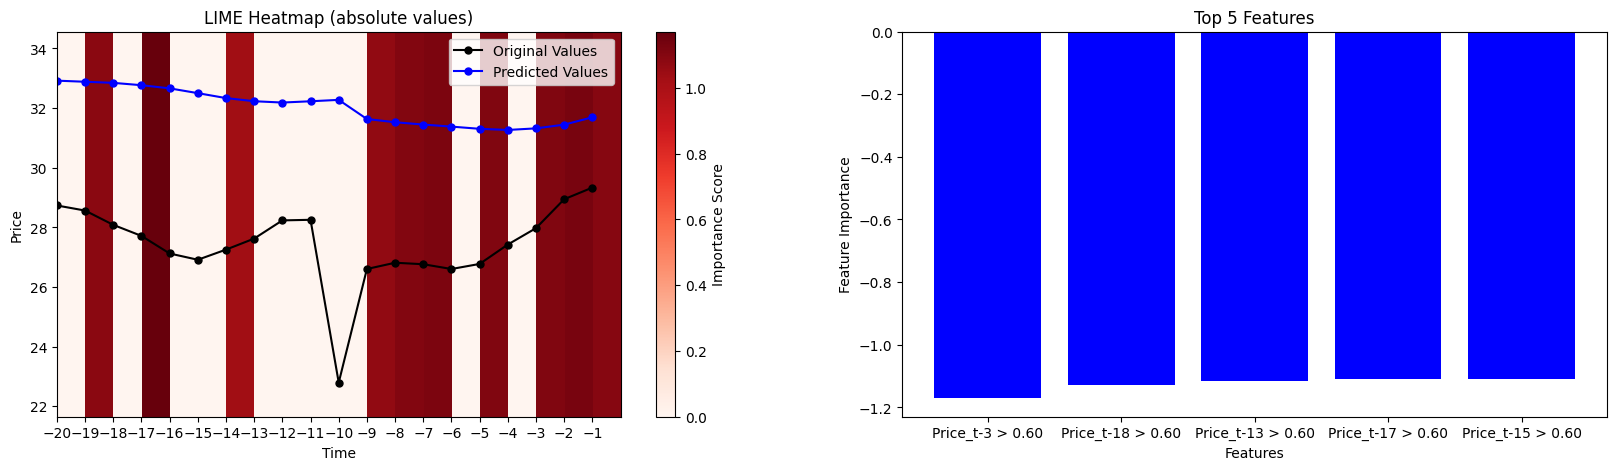

Intercept 11.356572226081349
Prediction_local [-36.30199642]
Right: -3171.578


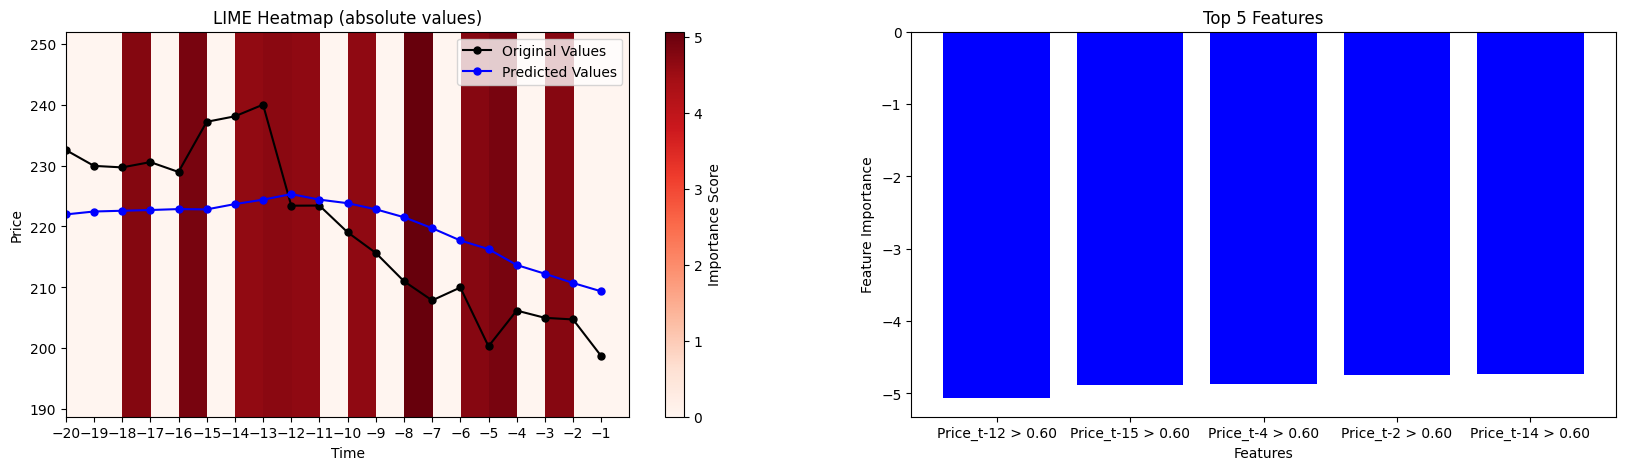

Intercept 13.499306574635378
Prediction_local [-43.79218768]
Right: -3694.6316


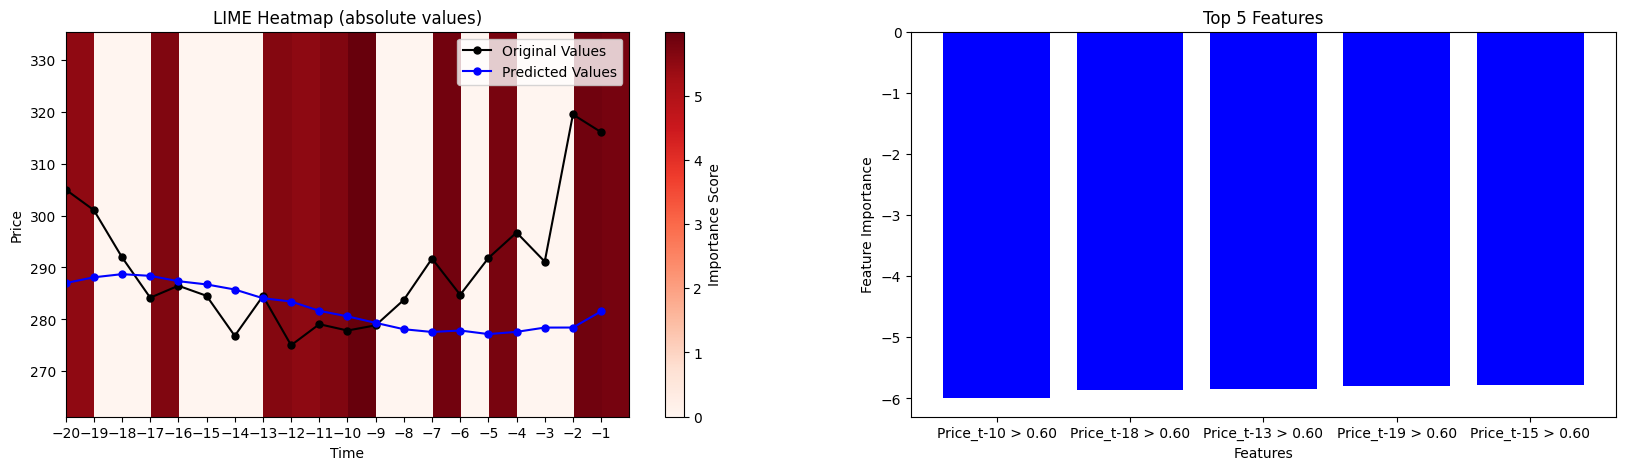

In [38]:
plot_lime_explanation_for_sample(400)
plot_lime_explanation_for_sample(1400)
plot_lime_explanation_for_sample(2000)